In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import geopandas as gpd

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 70)
os.chdir('../')
import data 
import losses
os.chdir('notebooks')

2023-02-22 10:33:56.561572: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
def _validate_target_predicted(target, predicted):
    """
    Validates target and predicted data. Both arguments 
    must have the same shape. If argument is a DataFrame, 
    this function converts it to a numpy array. 
    """
    
    if isinstance(target, pd.DataFrame) or isinstance(target, pd.Series):
        target = target.values
        
    if isinstance(predicted, pd.DataFrame) or isinstance(predicted, pd.Series):
        predicted = predicted.values
    
    assert isinstance(target, np.ndarray)
    assert isinstance(predicted, np.ndarray)
    assert target.shape == predicted.shape
    
    return target, predicted

def stats(target, predicted, func, bs_se = False):
    if bs_se:
        return func(target, predicted), bootstrap_se(target, predicted, func)
    return func(target, predicted)

def MAAPE(target, predicted, axis = None):
    """ Mean Abosulute Arctangent Percentual Error """
    target, predicted = _validate_target_predicted(target, predicted)
        
    return 100 * np.arctan(np.abs((target - predicted)/(target + 1e-9))).mean(axis = axis)

def wMAPE(target, predicted, axis = None):
    """ Weighted Mean Abosulute Percentual Error """
    target, predicted = _validate_target_predicted(target, predicted)
    
    num = np.abs(target - predicted).sum(axis = axis)
    dem = np.abs(target).sum(axis = axis)
    return 100*num/dem

def sMAPE(target, predicted, axis = None):
    """ symetric Mean Abosulute Percentual Error """
    target, predicted = _validate_target_predicted(target, predicted)
    
    num = np.abs(target-predicted)
    dem = np.abs(target) + np.abs(predicted)
    return 100*np.nan_to_num(num/dem).mean(axis = axis)

def RMSE(target, predicted, axis = None):
    """ symetric Mean Abosulute Percentual Error """
    target, predicted = _validate_target_predicted(target, predicted)
    
#     mse = np.square(np.subtract(target,predicted)).mean(axis = axis)
    mse = np.mean((target-predicted)**2, axis = axis)
    return np.sqrt(mse)

def MAE(target, predicted, axis = None):
    """ symetric Mean Abosulute Percentual Error """
    target, predicted = _validate_target_predicted(target, predicted)
    return np.mean(np.abs(target-predicted), axis = axis)

def bootstrap_se(target, predicted, func):
    """ Bootsrap function to estimate the standard error of 'func'
    
    Parameters: 
    - target: 1-d array-like. Target data of size n
    - predicted: 1-d array-like. Predicted data of size n
    - func: func. inputs of the function are target, predicted and axis. 
    
    Return: 
    estimated standard error of 'func' via bootstrap. 
    """
    target, predicted = _validate_target_predicted(target, predicted)
    target = target.flatten()
    predicted = predicted.flatten()
    
    indices = np.random.choice(target.size, size = (1000,1000), replace=True)
    target_sample = target[indices]
    predicted_sample = predicted[indices]
    
    return func(target_sample, predicted_sample, axis = 1).std()

def summary_erros(target, predictions, filter_obs = None):
    """
    Summary table for accuracy metrics
    
    Parameters:
    - target: 
    - predictions: list. List of dataframes. Each dataframe 
                   must contain df.name where name is the the 
                   model where the prediction is from. 
    """
    
    assert isinstance(predictions, list)
#     error_list = [RMSE, MAE, MAAPE, wMAPE, sMAPE]
#     error_name = ['RMSE', 'MAE','MAAPE', 'wMAPE', 'sMAPE']
    error_list = [ MAAPE, wMAPE, sMAPE]
    error_name = ['MAAPE', 'wMAPE', 'sMAPE']
    results = {}
    
    if filter_obs:
        target = target[:]
    
    
    for p in predictions:
        model = p.name
        error_dict = {}
        
        if filter_obs:
            t = target[filter_obs[0]:filter_obs[1]]
            p = p[filter_obs[0]:filter_obs[1]]
        else:
            t = target
        
        for func, name in zip(error_list, error_name):
            error = func(t, p)
            std = bootstrap_se(t, p, func)
            error_dict[name] = "{:.2f} (\u00B1{:.2f})".format(error,1.96*std)
        
        results[model] = error_dict
        
    print(pd.DataFrame(results).T.style.to_latex(caption = 'Summary accuracy metrics', 
                                                 position_float='centering', 
                                                 hrules = True))
    
    
def error_plots(target, predictions, stations, start_date, end_date, func, func_name, 
                 rolling_period = 76):
    
    # Estimate error of stations
    results = []
    for station in stations: 
        df_dict = {}
        for prediction in predictions:
            prediction_name = prediction.name
            values = func(target[[station]], prediction[[station]], axis = 1)
            df_dict[prediction_name] = values

        df = pd.DataFrame(df_dict, index = target.index)
        df.name = station
        results.append(df)
        
    #Plot
    fig, axs = plt.subplots(nrows = len(results), figsize = (20,20))
    for i, s in enumerate(results):
        s[start_date:end_date].rolling(rolling_period).mean().plot(ax = axs[i])
        axs[i].set_title(s.name, fontsize = 20)
        axs[i].set_xlabel('')
        axs[i].set_ylabel(func_name, fontsize = 20)
        axs[i].tick_params(labelrotation=0)
        
def target_prediction_plot(target, prediction, stations, start_date, end_date):
    
    fig, axs = plt.subplots(nrows = len(stations), figsize = (20,20))
    
    for i, station in enumerate(stations):
        target[station][start_date:end_date].plot(ax = axs[i], legend = True, label = 'Target')
        prediction[station][start_date:end_date].plot(ax = axs[i], 
                                                      legend = True, 
                                                      label = 'Prediction: {}'.format(prediction.name))
        axs[i].set_title(station, fontsize = 20)
        axs[i].set_xlabel('')
        axs[i].set_ylabel('Demand', fontsize = 20)
        axs[i].tick_params(labelrotation=0)

## Data Upload

In [3]:
target = data.clean_data('../../data/transactions.parquet')
target = target.iloc[1064:,:-8]
# print('UPLOAD DATA:')
# print("Target Shape: {}".format(target.shape))


# experiments = ['exp_1_2023_01_18.parquet',
#                 'exp2_2023_01_20.parquet',
#                 'predictions_2023_01_24_exp3.parquet',
#                 'predictions_2023_01_24_exp4.parquet',
#                 'predictions_2023_01_25_exp5.parquet',
#                 'predictions_2023_01_25_exp6.parquet']

# results = []

# for i, exp in enumerate(experiments):
#     df = pd.read_parquet('../outputs/{}'.format(exp))
#     df.name = "Experiment {}".format(i+1)
#     results.append(df)
#     print("Experiment {} shape: {}".format(i+1, df.shape))

In [ ]:
summary_erros(filtered_target, filter_predictions)

In [ ]:
# All Predictions
summary_erros(target, results, filter_obs = (83296,158536))

In [ ]:
# Only Stable Times
summary_erros(target, results, filter_obs = (83296,127000))

In [ ]:
# Only Unstable Times
summary_erros(target, results, filter_obs = (127000,158536))

Conclusion of the experimets: 
- Adding both temporal and spatial correlation does not improve model performace, it actually makes it worse. I don't understand why :( 
- Results are simular in magnitude with DFDeep results and other relevant papers (Not sure if they are the best results). Althought it doesn't appear to be statistically significant. It is hard to compare because DFDeep was only perform for few stations - mine is all stations. 
- Adding Stations Clousures only improved the sMAPE significantly.
- There seems to be a huge problem with the PEAKS -- It not predicting them very well at all. 

In [ ]:
stations = ['(09110) avenida jimenez','(14004) museo del oro', '(14005) las aguas']
errors = [MAAPE, wMAPE, sMAPE]
errors_name = ['MAAPE', 'wMAPE', 'sMAPE']
# models = [df]
# df.name = "transformer"

# error_plots(target, df, stations, start_date, end_date, func, func_name, 
#                  rolling_period = 76)

error_plots(target, 
            predictions = [results[5]],
            stations = stations,
            start_date = '2016-08-25', 
            end_date = '2016-09-10',
            func = sMAPE, 
            func_name = 'sMAPE', 
            rolling_period = 1,
           )

In [ ]:
stations = ['(09110) avenida jimenez','(14004) museo del oro', '(14005) las aguas']
errors = [MAAPE, wMAPE, sMAPE]
errors_name = ['MAAPE', 'wMAPE', 'sMAPE']
# models = [r1,r2,r3]

target_prediction_plot(target, 
                       results[5], 
                       stations, 
                       start_date = '2016-08-25', 
                       end_date = '2016-09-10')

# Individual Station Analysis

What are the stations that are more often close in my testing stable dataset? 

In [4]:
def read_stations(path):
    stations_df = pd.read_parquet(path)
    stations_df['station_name'] = [data.strip_accents(col) for col in stations_df.station_name.astype(str)]
    stations_df = stations_df[['station_name','latitude','longitude']].drop_duplicates(subset = 'station_name')
    return stations_df                                                                  
stations = read_stations('../../data/stations_DB.parquet').dropna()

In [5]:
def probability_clousure(series):
    series = series.values.reshape((-1,76)) #Organize in matrix size n x t
    series = series == 0 #True when station is close
    series = series[:,8:-4] #Filter only from 6 am to 10 pm
    series = np.cumsum(series, axis = 1) #Accumulated Number of periods stations are close
    series = np.max(series, axis = 1) #Max number of periods station is close by day
    return (series >= 4).mean() # Stations close for at least 1 hour

In [ ]:
df = target[83296:127000]
df = df.iloc[:-4]
probs = [probability_clousure(df[station]) for station in df.columns]
probs = pd.DataFrame(probs, index = df.columns, columns = ['clousure_probability'])
probs.sort_values(by = 'clousure_probability', ascending = False).head(5)

In [ ]:
merge_stations = stations.merge(probs, how = 'left', left_on = 'station_name', right_index = True).dropna()

gdf = gpd.GeoDataFrame(
    merge_stations, 
    geometry=gpd.points_from_xy(merge_stations.longitude, merge_stations.latitude))

gdf.plot(
    column = 'clousure_probability',
    figsize = (10,10), legend = True,
    cmap = 'RdYlGn');

### Analysis Museo del Oro

In [ ]:
#Target:
df_target = target[83296:127000].iloc[:-4]

df_predicted = results[-1][83296:127000].iloc[:-4]

print("Target Shape: {}".format(df_target.shape))
print("Predictions Shape: {}".format(df_predicted.shape))

In [ ]:
closed = df_target['(14004) museo del oro'] == 0
closed = closed.values

In [ ]:
stations = ['(09110) avenida jimenez','(14004) museo del oro', '(14005) las aguas']
stations = ['(09110) avenida jimenez','(14005) las aguas']
target_close = df_target[stations][closed]
target_open = df_target[stations][~closed]

predicted_close = df_predicted[stations][closed]
predicted_open = df_predicted[stations][~closed]

In [ ]:
mean_closed, se_close = stats(target_close, predicted_close, sMAPE, bs_se = True)
mean_open, se_open = stats(target_open, predicted_open, sMAPE, bs_se = True)
print (mean_closed, se_close)
print (mean_open, se_open)
print ("Diff: {}".format(mean_closed-mean_open))

In [10]:
close_station = '(14004) museo del oro'
nearby_stations = ['(09110) avenida jimenez','(14005) las aguas']

def close_stations_difference(target, results, close_station_name, nearby_stations):

    df_target = target#[83296:127000].iloc[:-4]
    closed = df_target[close_station_name] == 0
    closed = closed.values

    #Target Values
    target_close = df_target[nearby_stations][closed]
    target_open = df_target[nearby_stations][~closed]

    metrics = {}
    for result in results:
        df_predicted = result#[83296:127000].iloc[:-4]
        predicted_close = df_predicted[nearby_stations][closed]
        predicted_open = df_predicted[nearby_stations][~closed]
        m_close, se_close = stats(target_close, predicted_close, sMAPE, bs_se = True)
        m_open, se_open = stats(target_open, predicted_open, sMAPE, bs_se = True)
        metrics[result.name] = {"All Open": "{:.2f} (\u00B1{:.2f})".format(m_open, se_open),
                                "One Close":"{:.2f} (\u00B1{:.2f})".format(m_close, se_close),
                                "Difference": "{:.2f}".format(m_open-m_close)}
        
    return pd.DataFrame(metrics).T

In [ ]:
filter_time = (target.index.hour > 5) & (target.index.hour < 22)
filtered_target = target[filter_time].loc['2018-08-01':'2020-03-15']

filter_predictions = []
for prediction in results:
    df = prediction[filter_time].loc['2018-08-01':'2020-03-15'] 
    df.name = prediction.name
    filter_predictions.append(df)

In [ ]:
close_station = '(14004) museo del oro'
nearby_stations = ['(09110) avenida jimenez','(14005) las aguas']

close_stations_difference(filtered_target, filter_predictions, close_station, nearby_stations)

In [ ]:
close_station = '(03014) san martin'
nearby_stations = ['(03013) rio negro', '(04107) escuela militar']

close_stations_difference(filtered_target, filter_predictions, close_station, nearby_stations)

In [ ]:
close_station = '(06107) ciudad universitaria'
nearby_stations = ['(06106) recinto ferial', '(06108) concejo de bogota']

close_stations_difference(filtered_target, filter_predictions, close_station, nearby_stations)

In [ ]:
close_station = '(07107) u. nacional'
nearby_stations = ['(07108) av. el dorado', '(07106) el campin']

close_stations_difference(filtered_target, filter_predictions, close_station, nearby_stations)

In [ ]:
close_station = '(14001) la sabana'
nearby_stations = ['(12004) carrera 22', '(09110) avenida jimenez']

close_stations_difference(filtered_target, filter_predictions, close_station, nearby_stations)

# Results with Other Models

Experimens 

- 1.LSTM - No closures considered
- 2.LSTM - Mask closures
- 3.LSTM - Dummy Closure
- 4.CNN - No closures considered
- 5.CNN - Mask closures
- 6.CNN - Dummy Closure
- 7.FNN - No closures considered
- 8.FNN - Mask closures
- 9.FNN - Dummy Closure
- 10.Transformer - No closures considered
- 11.Transformer - Mask closures
- 12.Transformer - Dummy Closure

In [6]:
target = data.clean_data('../../data/transactions.parquet')
target = target.iloc[1064:,:-8]

df_target = target[83296:127000].iloc[:-4]

In [7]:
# Loading Results
experiments = ['1_lstm_None_lstm_predictions.parquet','2_lstm_mask_lstm_predictions.parquet',
               '3_lstm_dummy_lstm_predictions.parquet', '4_fnn_None_fnn_predictions.parquet', 
               '5_fnn_mask_fnn_predictions.parquet', '6_fnn_dummy_fnn_predictions.parquet',
               '7_cnn_None_cnn_predictions.parquet', '8_cnn_mask_cnn_predictions.parquet', 
               '9_cnn_dummy_cnn_predictions.parquet', 
               '10_transformer_None_transformer_predictions.parquet',
               '11_transformer_mask _transformer_predictions.parquet',
               '12_transformer_dummy_transformer_predictions.parquet', 
               '13_gnn_None_gnn_predictions.parquet', 
               '14_gnn_mask _gnn_predictions.parquet',
               '15_gnn_dummy_gnn_predictions.parquet']

results = []

for i, exp in enumerate(experiments):
    df = pd.read_parquet('../outputs/{}'.format(exp))
    df.name = exp[:11]
    results.append(df)
    print("Experiment {} shape: {}".format(i+1, df.shape))

Experiment 1 shape: (158536, 147)
Experiment 2 shape: (158536, 147)
Experiment 3 shape: (158536, 147)
Experiment 4 shape: (158536, 147)
Experiment 5 shape: (158536, 147)
Experiment 6 shape: (158536, 147)
Experiment 7 shape: (158536, 147)
Experiment 8 shape: (158536, 147)
Experiment 9 shape: (158536, 147)
Experiment 10 shape: (158536, 147)
Experiment 11 shape: (158536, 147)
Experiment 12 shape: (158536, 147)
Experiment 13 shape: (158536, 147)
Experiment 14 shape: (158536, 147)
Experiment 15 shape: (158536, 147)


In [8]:
filter_time = (target.index.hour > 5) & (target.index.hour < 22)
filtered_target = target[filter_time].loc['2018-08-01':'2020-03-15']

filter_predictions = []
for prediction in results:
    df = prediction[filter_time].loc['2018-08-01':'2020-03-15'] 
    df.name = prediction.name
    filter_predictions.append(df)

In [18]:
#All stations performace:
summary_erros(filtered_target, filter_predictions)

\begin{table}
\centering
\caption{Summary accuracy metrics}
\begin{tabular}{llll}
\toprule
 & MAAPE & wMAPE & sMAPE \\
\midrule
1_lstm_None & 19.06 (±1.46) & 11.34 (±1.03) & 9.96 (±0.80) \\
2_lstm_mask & 28.18 (±1.82) & 14.51 (±1.23) & 21.08 (±1.67) \\
3_lstm_dumm & 21.95 (±1.52) & 12.58 (±1.08) & 13.73 (±1.20) \\
4_fnn_None_ & 21.80 (±1.54) & 12.25 (±1.07) & 12.46 (±1.06) \\
5_fnn_mask_ & 21.49 (±1.39) & 13.21 (±1.21) & 11.72 (±0.80) \\
6_fnn_dummy & 22.33 (±1.67) & 12.04 (±1.02) & 11.25 (±0.86) \\
7_cnn_None_ & 22.04 (±1.56) & 12.78 (±1.13) & 13.75 (±1.16) \\
8_cnn_mask_ & 21.50 (±1.39) & 12.43 (±1.11) & 13.96 (±1.17) \\
9_cnn_dummy & 21.61 (±1.53) & 11.74 (±1.04) & 10.84 (±0.88) \\
10_transfor & 22.12 (±1.39) & 16.55 (±1.57) & 11.55 (±0.83) \\
11_transfor & 20.42 (±1.20) & 16.07 (±1.50) & 10.62 (±0.62) \\
12_transfor & 19.59 (±1.19) & 14.84 (±1.40) & 9.96 (±0.62) \\
13_gnn_None & 18.45 (±1.20) & 13.27 (±1.31) & 9.62 (±0.70) \\
14_gnn_mask & 17.12 (±1.09) & 12.03 (±1.22) & 8.63 (±0.5

In [11]:
close_station = '(14004) museo del oro'
nearby_stations = ['(09110) avenida jimenez','(14005) las aguas']

close_stations_difference(filtered_target, filter_predictions, close_station, nearby_stations)

,All Open,One Close,Difference
1_lstm_None,5.97 (±0.23),15.67 (±0.69),-9.69
2_lstm_mask,8.49 (±0.35),27.43 (±1.02),-18.94
3_lstm_dumm,8.50 (±0.35),21.25 (±0.85),-12.76
4_fnn_None_,7.92 (±0.30),19.61 (±0.78),-11.69
5_fnn_mask_,8.22 (±0.28),17.15 (±0.63),-8.93
6_fnn_dummy,8.78 (±0.35),18.70 (±0.75),-9.92
7_cnn_None_,7.22 (±0.27),26.45 (±0.91),-19.23
8_cnn_mask_,7.36 (±0.30),19.42 (±0.86),-12.07
9_cnn_dummy,6.75 (±0.23),17.27 (±0.72),-10.51
10_transfor,10.70 (±0.31),17.75 (±0.68),-7.05


In [12]:
close_station = '(03014) san martin'
nearby_stations = ['(03013) rio negro', '(04107) escuela militar']

close_stations_difference(filtered_target, filter_predictions, close_station, nearby_stations)

,All Open,One Close,Difference
1_lstm_None,12.26 (±0.36),30.14 (±0.88),-17.88
2_lstm_mask,44.46 (±1.07),88.19 (±0.92),-43.73
3_lstm_dumm,21.84 (±0.64),49.63 (±1.11),-27.79
4_fnn_None_,16.90 (±0.57),42.17 (±1.05),-25.27
5_fnn_mask_,15.41 (±0.49),31.06 (±0.85),-15.65
6_fnn_dummy,14.05 (±0.42),33.31 (±0.85),-19.26
7_cnn_None_,23.73 (±0.65),45.57 (±1.15),-21.84
8_cnn_mask_,24.38 (±0.79),55.64 (±1.22),-31.26
9_cnn_dummy,13.81 (±0.41),28.47 (±0.83),-14.66
10_transfor,13.44 (±0.38),27.23 (±0.83),-13.78


In [13]:
close_station = '(06107) ciudad universitaria'
nearby_stations = ['(06106) recinto ferial', '(06108) concejo de bogota']

close_stations_difference(filtered_target, filter_predictions, close_station, nearby_stations)

,All Open,One Close,Difference
1_lstm_None,11.26 (±0.36),28.02 (±0.94),-16.76
2_lstm_mask,30.02 (±0.93),31.16 (±0.88),-1.14
3_lstm_dumm,24.02 (±0.84),40.23 (±1.08),-16.21
4_fnn_None_,15.02 (±0.53),29.98 (±0.98),-14.96
5_fnn_mask_,13.68 (±0.44),17.88 (±0.57),-4.20
6_fnn_dummy,12.28 (±0.41),25.50 (±0.95),-13.22
7_cnn_None_,24.66 (±0.88),41.19 (±1.01),-16.53
8_cnn_mask_,23.71 (±0.85),34.65 (±0.92),-10.94
9_cnn_dummy,12.85 (±0.42),31.15 (±0.90),-18.30
10_transfor,12.89 (±0.42),28.60 (±0.90),-15.71


In [14]:
close_station = '(07107) u. nacional'
nearby_stations = ['(07108) av. el dorado', '(07106) el campin']

close_stations_difference(filtered_target, filter_predictions, close_station, nearby_stations)

,All Open,One Close,Difference
1_lstm_None,9.45 (±0.31),56.93 (±1.35),-47.49
2_lstm_mask,20.91 (±0.78),10.87 (±0.53),10.03
3_lstm_dumm,13.16 (±0.51),60.06 (±1.32),-46.91
4_fnn_None_,12.08 (±0.45),56.50 (±1.40),-44.42
5_fnn_mask_,12.80 (±0.50),10.55 (±0.60),2.25
6_fnn_dummy,10.01 (±0.33),54.68 (±1.46),-44.67
7_cnn_None_,13.70 (±0.52),62.05 (±1.26),-48.35
8_cnn_mask_,14.83 (±0.58),11.53 (±0.54),3.30
9_cnn_dummy,10.61 (±0.33),55.37 (±1.27),-44.76
10_transfor,10.57 (±0.34),60.41 (±1.31),-49.84


In [15]:
close_station = '(14001) la sabana'
nearby_stations = ['(12004) carrera 22', '(09110) avenida jimenez']

close_stations_difference(filtered_target, filter_predictions, close_station, nearby_stations)

,All Open,One Close,Difference
1_lstm_None,9.15 (±0.39),29.52 (±1.15),-20.36
2_lstm_mask,18.37 (±0.89),22.80 (±1.04),-4.42
3_lstm_dumm,13.43 (±0.63),33.13 (±1.19),-19.69
4_fnn_None_,13.40 (±0.63),33.24 (±1.18),-19.84
5_fnn_mask_,12.05 (±0.48),13.18 (±0.58),-1.13
6_fnn_dummy,11.21 (±0.44),30.01 (±1.20),-18.80
7_cnn_None_,12.51 (±0.60),32.57 (±1.20),-20.06
8_cnn_mask_,12.04 (±0.57),14.79 (±0.75),-2.75
9_cnn_dummy,10.00 (±0.42),27.97 (±1.14),-17.97
10_transfor,12.13 (±0.37),35.01 (±1.02),-22.88


# Testing Log Transformation

In [3]:
target_df = target.iloc[:8936]

In [8]:
max_value = np.log1p(target.values).max()
min_value = np.log1p(target.values).min()

In [39]:
df_1 = pd.read_parquet('../outputs/lstm_example_lstm_predictions.parquet')
df_1.name = 'LSTM - log Transformation'

df_2 = pd.read_parquet('../outputs/lstm_example_minmax_lstm_predictions.parquet')
df_2.name = 'LSTM - MinMax Transformation'

df_3 = pd.read_parquet('../outputs/lstm_example_standard_lstm_predictions.parquet')
df_3.name = 'LSTM - Standard Transformation'

df_4 = pd.read_parquet('../outputs/lstm_example_logminmax_lstm_predictions.parquet')
# df_4 = (df_4 * (max_value - min_value) + min_value).apply(np.expm1)
df_4.name = 'LSTM - LogMinMax Transformation'

In [42]:
summary_erros(target_df, [df_1, df_2, df_3, df_4])

\begin{table}
\centering
\caption{Summary accuracy metrics}
\begin{tabular}{llllll}
\toprule
 & RMSE & MAE & MAAPE & wMAPE & sMAPE \\
\midrule
LSTM - log Transformation & 54.44 (±15.49) & 23.20 (±3.01) & 16.04 (±1.06) & 12.13 (±1.18) & 8.36 (±0.56) \\
LSTM - MinMax Transformation & 56.65 (±12.12) & 34.58 (±2.79) & 35.58 (±2.45) & 18.09 (±1.80) & 22.12 (±1.78) \\
LSTM - Standard Transformation & 61.88 (±7.81) & 31.59 (±3.38) & 29.02 (±2.60) & 16.52 (±2.22) & 16.30 (±1.60) \\
LSTM - LogMinMax Transformation & 76.34 (±20.48) & 31.91 (±4.24) & 20.61 (±1.33) & 16.69 (±1.61) & 9.71 (±0.58) \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
target_df.columns[:2]

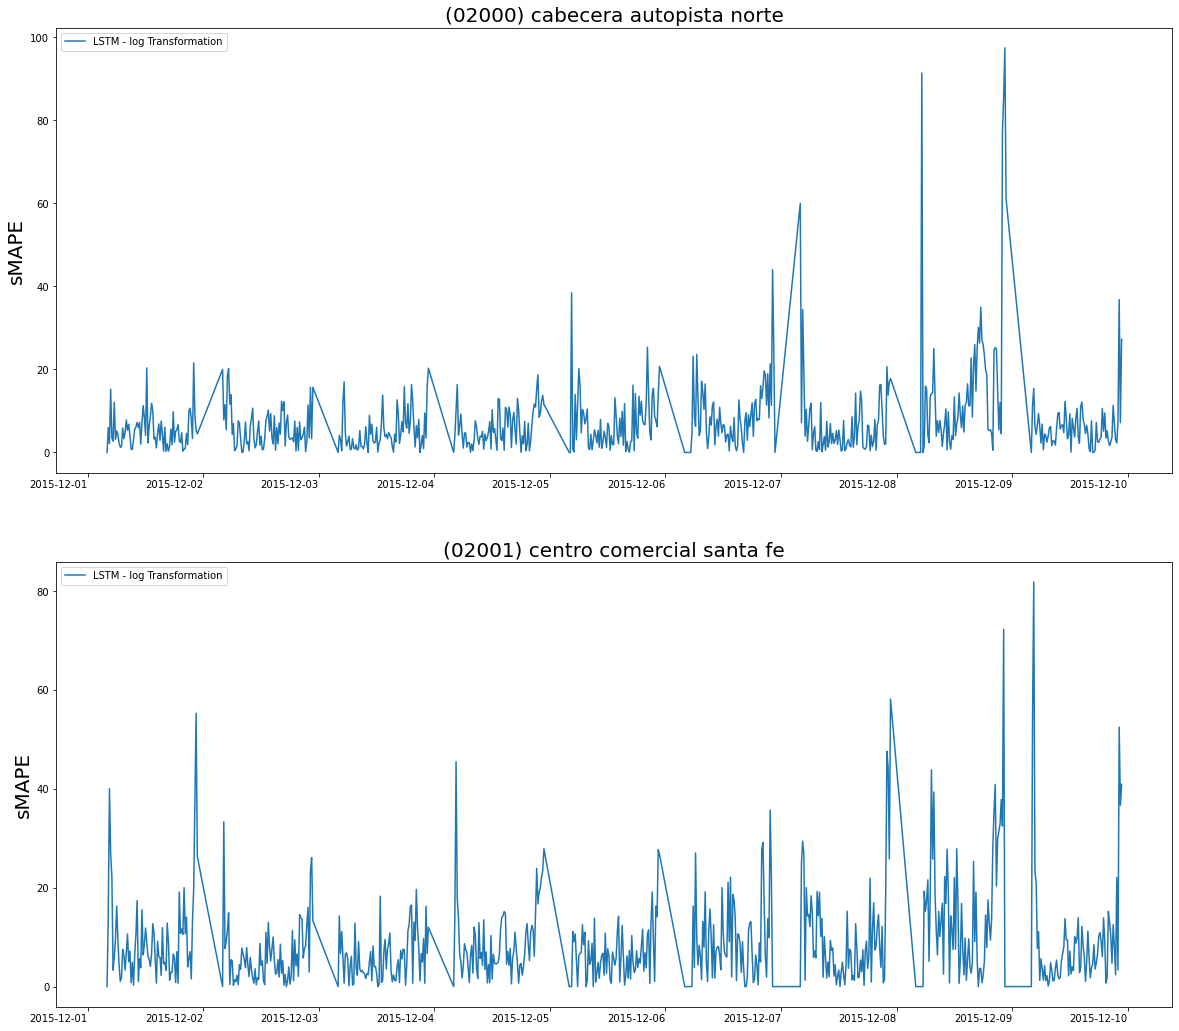

In [44]:
stations = ['(02000) cabecera autopista norte','(02001) centro comercial santa fe']
errors = [MAAPE, wMAPE, sMAPE]
errors_name = ['MAAPE', 'wMAPE', 'sMAPE']
# models = [df]
# df.name = "transformer"

# error_plots(target, df, stations, start_date, end_date, func, func_name, 
#                  rolling_period = 76)

error_plots(target_df, 
            predictions = [df_1],
            stations = stations,
            start_date = '2015-12-01', 
            end_date = '2015-12-09',
            func = sMAPE, 
            func_name = 'sMAPE', 
            rolling_period = 1,
           )

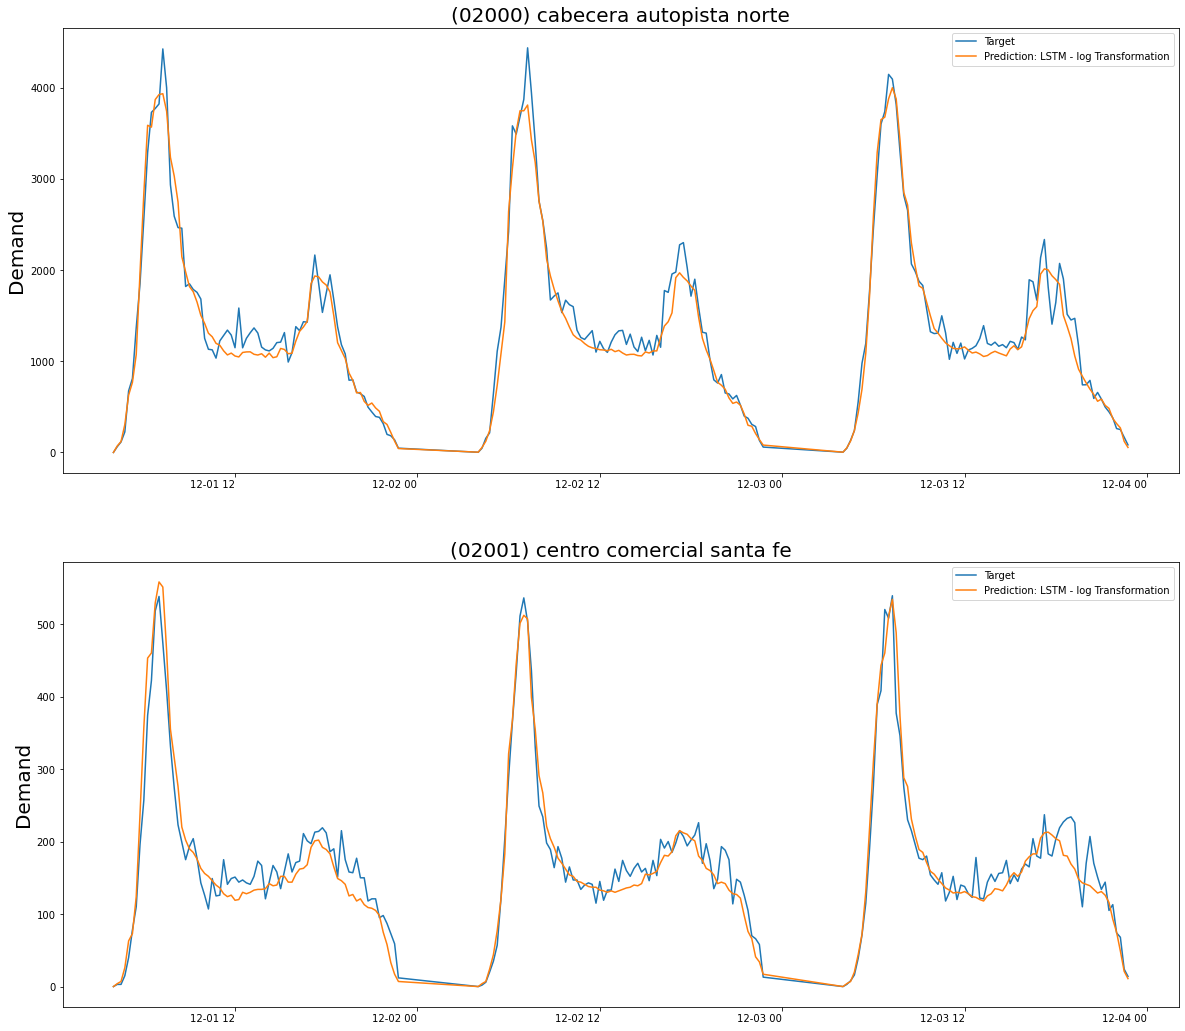

In [48]:
# stations = ['(09110) avenida jimenez','(14004) museo del oro', '(14005) las aguas']
stations = ['(02000) cabecera autopista norte','(02001) centro comercial santa fe']
errors = [MAAPE, wMAPE, sMAPE]
errors_name = ['MAAPE', 'wMAPE', 'sMAPE']
# models = [r1,r2,r3]

target_prediction_plot(target_df, 
                       df_1, 
                       stations, 
                       start_date = '2015-12-01', 
                       end_date = '2015-12-03')

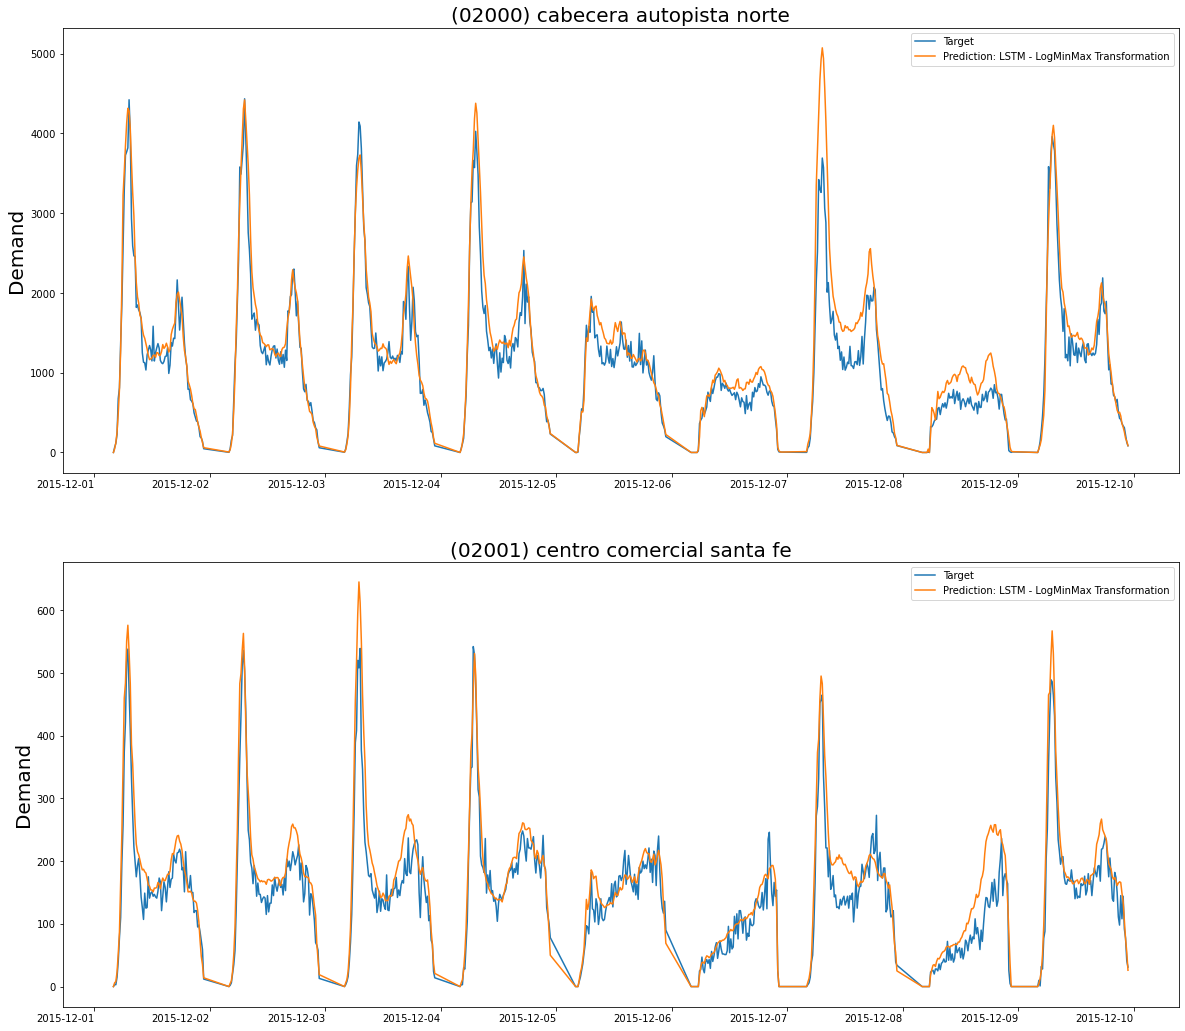

In [47]:
# stations = ['(09110) avenida jimenez','(14004) museo del oro', '(14005) las aguas']
stations = ['(02000) cabecera autopista norte','(02001) centro comercial santa fe']
errors = [MAAPE, wMAPE, sMAPE]
errors_name = ['MAAPE', 'wMAPE', 'sMAPE']
# models = [r1,r2,r3]

target_prediction_plot(target_df, 
                       df_4, 
                       stations, 
                       start_date = '2015-12-01', 
                       end_date = '2015-12-09')

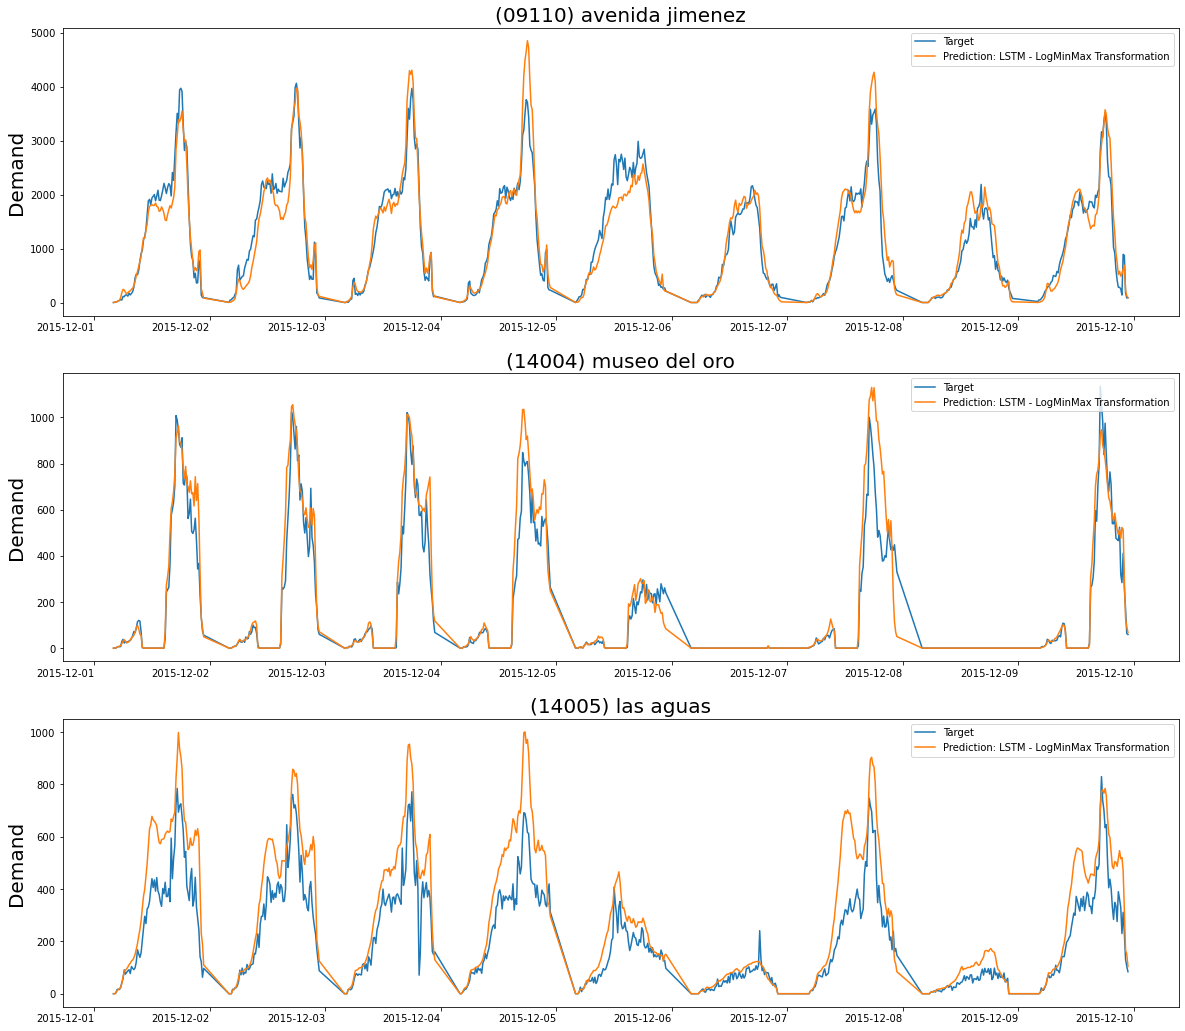

In [46]:
stations = ['(09110) avenida jimenez','(14004) museo del oro', '(14005) las aguas']
errors = [MAAPE, wMAPE, sMAPE]
errors_name = ['MAAPE', 'wMAPE', 'sMAPE']
# models = [r1,r2,r3]

target_prediction_plot(target_df, 
                       df_4, 
                       stations, 
                       start_date = '2015-12-01', 
                       end_date = '2015-12-09')

# Analysis Brainstorming

In [ ]:
# filtered_target
# filter_predictions[11]

In [ ]:
t = filtered_target.values.flatten() 
p = filter_predictions[0].values.flatten()
r = pd.DataFrame(data = {'target': t, 'predicted': p})
r.plot.scatter(x = 'predicted', y ='target', figsize = (20,20));

In [ ]:
target.columns

In [ ]:
target.max().max()

In [ ]:
b = pd.cut(target['(02000) cabecera autopista norte'], bins = range(0, 8200, 10), right = False, labels = range(0, 819))

In [ ]:
b.astype(int).loc["2018-08-01":"2018-08-07"].plot(figsize = (20,10))

In [ ]:
a = target.replace({0:np.nan}).values.flatten()
a = pd.Series(a[~np.isnan(a)])

In [ ]:
target.apply(np.log1p)['(02000) cabecera autopista norte'].loc["2018-08-01":"2018-08-07"].plot(figsize = (20,10))

In [ ]:
target.apply(np.log1p).boxplot(column = list(target.columns[:10]), figsize = (20,20))

In [ ]:
target.columns[:10]

In [ ]:
a.apply(np.log1p).plot.hist(bins = 100)

In [ ]:
target.apply(np.log1p).groupby(target.index.hour).mean().mean(axis = 1).plot()

In [ ]:
from scipy.stats import boxcox

target_bc = target.copy()
# Iterate over all columns in the data frame
for column in target_bc.columns:
    # Skip the transformation if the column contains non-numeric values
    if target_bc[column].dtype in [np.float64, np.int64]:
        # Determine the optimal lambda value
        lambda_value, _ = boxcox(target_bc[column]+1)

        # Apply the transformation to the entire column
        target_bc[column] = boxcox(target_bc[column]+1, lmbda=lambda_value)

In [ ]:
lambda_value

In [ ]:
target_bc.groupby(target.index.hour).mean().mean(axis = 1).plot()

In [ ]:
target.groupby(target.index.hour).std().mean(axis = 1).plot()

In [ ]:
r = sMAPE(filtered_target, filter_predictions[0], axis = 1)
r = pd.DataFrame(r, index = filtered_target.index )

fig, axs = plt.subplots(nrows = 1, ncols=3, figsize = (20, 5))

r.groupby(r.index.hour).mean().plot(ax = axs[0], title = "Hours" )
r.groupby(r.index.dayofweek).mean().plot(ax = axs[1], title = "Days of the week")
r.groupby(r.index.month).mean().plot(ax = axs[2], title = "Months" );
# r.plot(figsize = (30,10))

In [ ]:
r = sMAPE(filtered_target, filter_predictions[11], axis = 1)
r = pd.DataFrame(r, index = filtered_target.index )

fig, axs = plt.subplots(nrows = 1, ncols=3, figsize = (20, 5))

r.groupby(r.index.hour).mean().plot(ax = axs[0], title = "Hours" )
r.groupby(r.index.dayofweek).mean().plot(ax = axs[1], title = "Days of the week")
r.groupby(r.index.month).mean().plot(ax = axs[2], title = "Months" );
# r.plot(figsize = (30,10))

In [ ]:
r = RMSE(filtered_target, filter_predictions[11], axis = 1)
r = pd.DataFrame(r, index = filtered_target.index )

fig, axs = plt.subplots(nrows = 1, ncols=3, figsize = (20, 5))

r.groupby(r.index.hour).mean().plot(ax = axs[0], title = "Hours" )
r.groupby(r.index.dayofweek).mean().plot(ax = axs[1], title = "Days of the week")
r.groupby(r.index.month).mean().plot(ax = axs[2], title = "Months" );

In [ ]:
r = MAE(filtered_target, filter_predictions[11], axis = 1)
r = pd.DataFrame(r, index = filtered_target.index )

fig, axs = plt.subplots(nrows = 1, ncols=3, figsize = (20, 5))

r.groupby(r.index.hour).mean().plot(ax = axs[0], title = "Hours" )
r.groupby(r.index.dayofweek).mean().plot(ax = axs[1], title = "Days of the week")
r.groupby(r.index.month).mean().plot(ax = axs[2], title = "Months" );

In [ ]:
r = MAAPE(filtered_target, filter_predictions[11], axis = 1)
r = pd.DataFrame(r, index = filtered_target.index )

fig, axs = plt.subplots(nrows = 1, ncols=3, figsize = (20, 5))

r.groupby(r.index.hour).mean().plot(ax = axs[0], title = "Hours" )
r.groupby(r.index.dayofweek).mean().plot(ax = axs[1], title = "Days of the week")
r.groupby(r.index.month).mean().plot(ax = axs[2], title = "Months" );

In [ ]:
pd.set_option('display.max_rows', 70)

In [ ]:
day = 67
r.iloc[ day*64: day*64+64]